In [1]:
import matplotlib.pyplot as plt
import dense_basis as db
import numpy as np
import sys

Initialized stellar population with FSPS.


[11.54645309 -0.46331223  1.          0.457921  ]


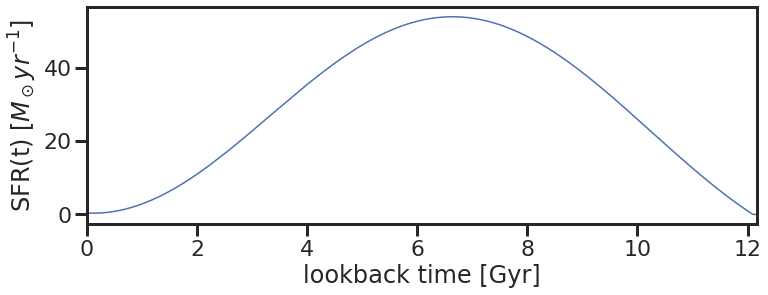

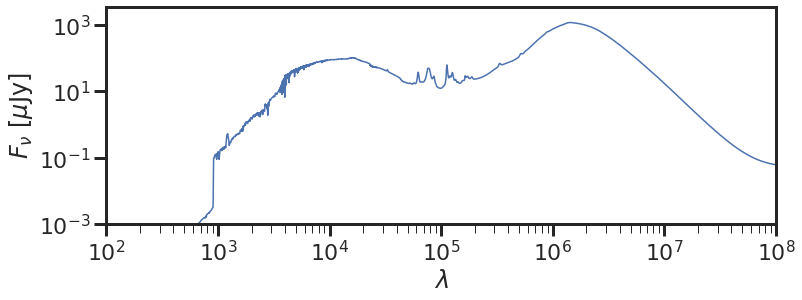

In [2]:
# sample from priors: M*, SFR, tx, Av, Z, z

rseed = 15

rand_sfh_tuple = db.sample_sfh_tuple(random_seed = rseed, Nparam = 1)
print(rand_sfh_tuple)

rand_sfh, rand_time = db.gp_sfh_sklearn(rand_sfh_tuple, zval = 0.1)

db.plot_sfh(rand_time, rand_sfh, lookback=True)

rand_sfh_tuple, rand_Z, rand_Av, rand_z = db.sample_all_params(random_seed = rseed, Nparam = 1)
rand_spec, rand_lam = db.make_spec(rand_sfh_tuple, rand_Z, rand_Av, rand_z, return_lam = True)

filter_list = 'dense_basis/filters/filter_list_goodss.dat'
rand_sed = db.calc_fnu_sed(rand_spec, rand_z, rand_lam, fkit_name = filter_list)

db.plot_spec(rand_lam, rand_spec)

sed_truths = (rand_sfh_tuple[0], rand_sfh_tuple[1], rand_sfh_tuple[-1], rand_Av, rand_Z)

# Let's try SED fitting using a pregrid + MCMC

since pure MCMC takes too long, let's load up the pre-grid and perform multidimensional interpolation in parameter space to get SEDs.

In [6]:
import emcee
import corner
from scipy.interpolate import NearestNDInterpolator

In [7]:
pg_sfhs, pg_Z, pg_Av, pg_z, pg_seds, norm_method = db.load_pregrid_sednorm('dense_basis/pregrids/sfh_pregrid_size_10000.mat')
pg_theta = [pg_sfhs, pg_Z, pg_Av, pg_z, pg_seds]
pg_params = np.vstack([pg_sfhs[0,0:], pg_sfhs[1,0:], pg_sfhs[3:,0:], pg_Z, pg_Av, pg_z])

In [8]:
def make_sed_from_pregrid(theta, pg_theta, pg_seds):
    interpolator = NearestNDInterpolator(pg_params.T, pg_seds.T)
    sed = interpolator(theta)
    return sed

In [9]:
example_theta = np.array([9.4,-0.5,0.4,0.2,0.08,0.91])
example_sed = interpolator(example_theta)
example_sed

NameError: name 'interpolator' is not defined

In [10]:
pg_seds[0:,15]

array([0.04963758, 0.04961686, 0.05018043, 0.09659305, 0.19375395,
       0.23084042, 0.3186732 , 0.3647241 , 0.39977235, 0.50027798,
       0.61038635, 0.88947605, 0.88939003, 1.        , 0.70989376,
       0.55158933, 0.35533031])

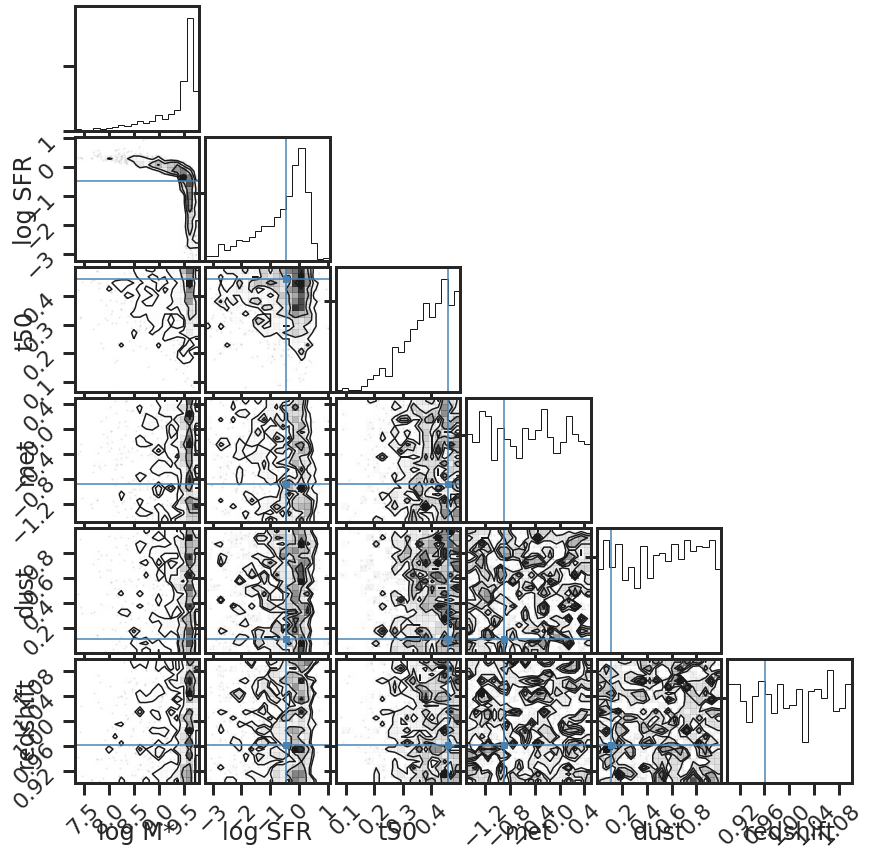

In [12]:
ndim, nwalkers, nsteps = 6, 1000, 1000

# mass, sfr, t50, 
# pos_min = np.array([7.24, -1.0, 0.1, -1.0, 0.0])
# pos_max = np.array([12.0, 1.0, 0.9, 0.5, 0.5])

# psize = pos_max - pos_min
# pos = [pos_min + psize*np.random.rand(ndim) for i in range(nwalkers)]

pos = pg_params[0:,np.random.choice(pg_params.shape[1], size = nwalkers)].T

fig = corner.corner(pos, labels = ['log M*', 'log SFR', 't50', 'met', 'dust','redshift'], 
                    truths = [rand_sfh_tuple[0], rand_sfh_tuple[1], rand_sfh_tuple[3], rand_Z, rand_Av,rand_z])
fig.set_size_inches(12,12)
plt.show()

In [13]:
# prior: uniform - rewrite to be conditional with multiple tx
def lnprior(theta):
    mstar, sfr, t50, Z, Av, z = theta
#     sfh_tuple = np.array([mstar, sfr, 1.0, t50])
    # mass, SFR. t50 values taken from normalized pregrid
    if 7.24 < mstar < 9.9 and -3.5 < sfr < 1.37 and 0.1 < t50 < 0.5 and -1.0 < Z < 0.5 and 0.0 < Av < 0.5 and 0.9<z<1.1:
        return 0.0
    return -np.inf

# likelihood chi^2
def lnlike(theta, sed, pg_theta, pg_seds):
    mstar, sfr, t50, Z, Av, z = theta
#     sfh_tuple = np.array([mstar, sfr, 1.0, t50])
#     model_sed = db.make_sed_fast(sfh_tuple, Z, Av, z_true, filcurves)
    model_sed = make_sed_from_pregrid(theta, pg_theta, pg_seds)
    chi2 = (sed-model_sed)**2 / (sed*0.03)**2
    return np.sum(-chi2/2)

def lnprob(theta, sed, pg_theta, pg_seds):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, sed, pg_theta, pg_seds)


In [14]:
sed_norm = np.amax(rand_sed)
rand_sed_normed = rand_sed/sed_norm
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (rand_sed_normed, pg_params, pg_seds), threads = 4)

In [15]:
import time

time0 = time.time()
pos, prob, state = sampler.run_mcmc(pos, 10)
sampler.reset()

time1 = time.time()
print(time1-time0)

8.805824756622314


In [16]:
time0 = time.time()

width = 100
for i, result in enumerate(sampler.sample(pos, iterations = nsteps)):
    n = int((width+1)*float(i)/nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n , ' '*(width-n)))
sys.stdout.write("\n")

time1 = time.time()
print(time1-time0)

[####################################################################################################]
1688.7719466686249


(1000, 1000, 6)


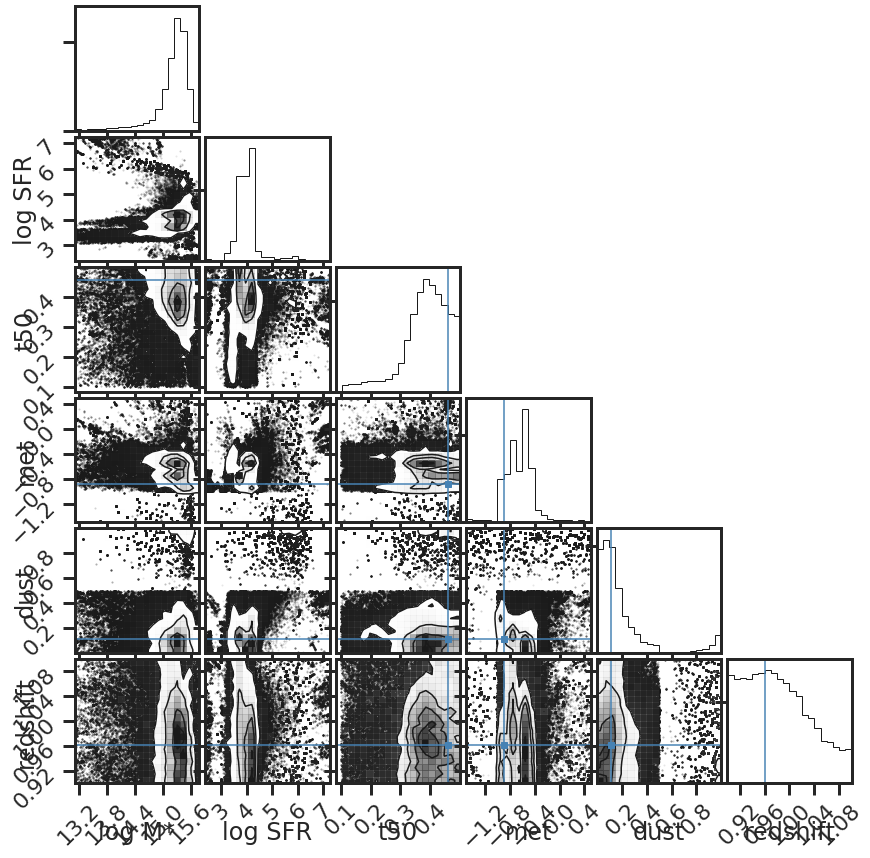

In [21]:
# 1000 walkers, 1000 steps ~ 126 sec
# 1000 walkers, 100 steps ~ 126 sec

samples = sampler.flatchain
print(sampler.chain.shape)

samples[0:,0] += np.log10(sed_norm)
samples[0:,1] += np.log10(sed_norm)

fig = corner.corner(samples, labels = ['log M*', 'log SFR', 't50', 'met', 'dust', 'redshift'], 
                    truths = [rand_sfh_tuple[0], rand_sfh_tuple[1], rand_sfh_tuple[3], rand_Z, rand_Av, rand_z])
fig.set_size_inches(12,12)
plt.show()


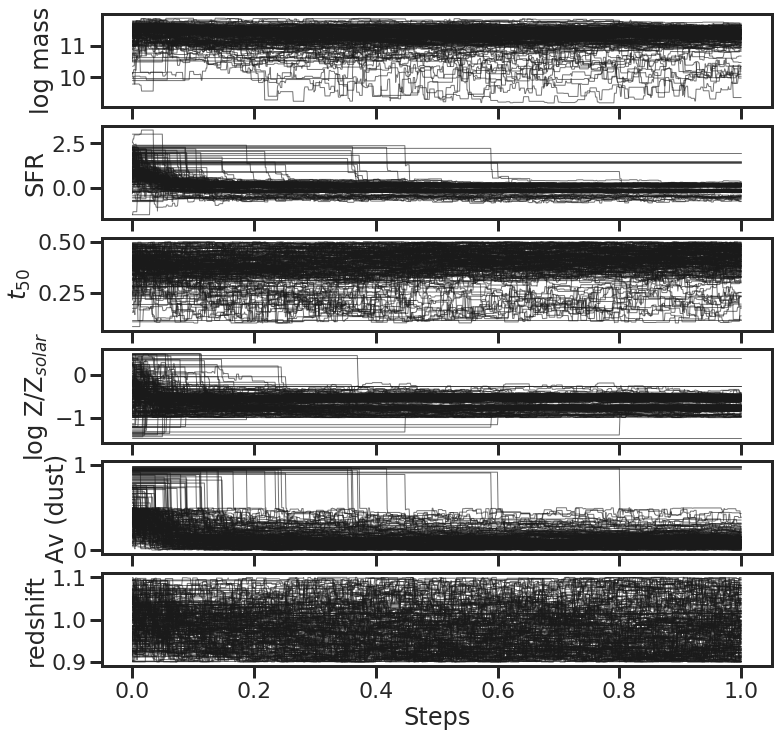

In [18]:
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(12, 12))
for i, [ax, param] in enumerate(zip(axes, ['log mass', r'SFR', r'$t_{50}$', r'log Z/Z$_{solar}$', 'Av (dust)','redshift'])):
    walkers = sampler.chain[:, :, i]
    for walker in walkers[::5]:
        ax.plot(np.linspace(0,1,nsteps), walker, lw=1.0, color='k', alpha=0.6)
    ax.set_ylabel(param)

#axes[ndim-1].set_yscale('log')
axes[ndim-1].set_xlabel('Steps');
plt.show()

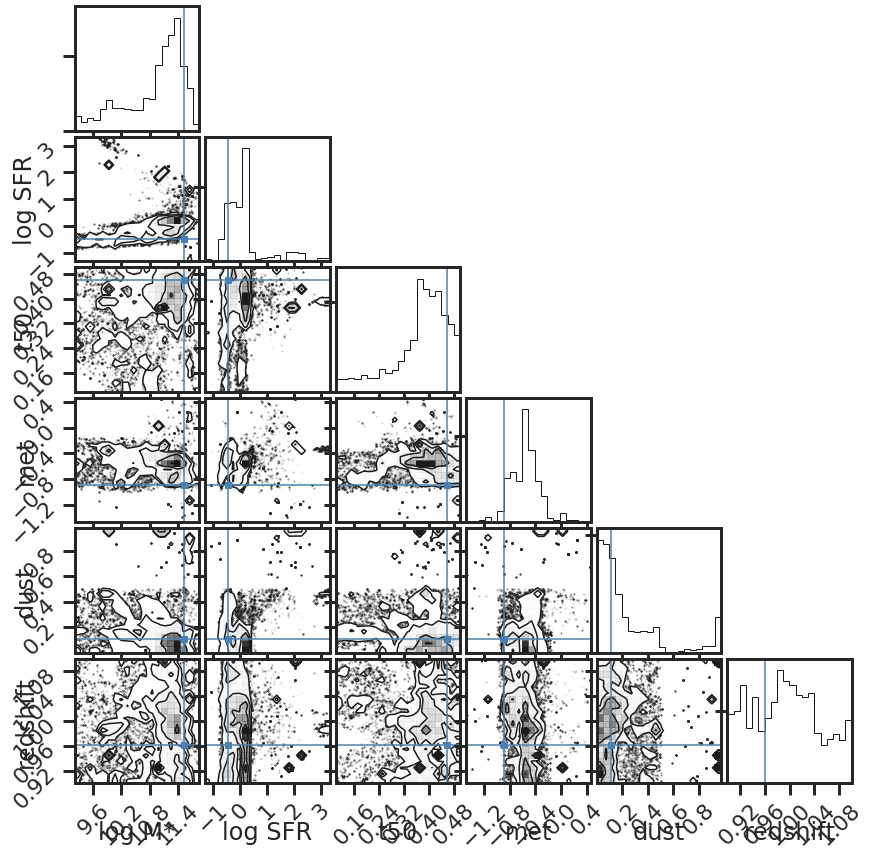

In [68]:
# 10 walkers, 1000 steps, ~ 80 seconds

samples = sampler.flatchain
samples.shape

samples[0:,0] += np.log10(sed_norm)
samples[0:,1] += np.log10(sed_norm)

fig = corner.corner(samples, labels = ['log M*', 'log SFR', 't50', 'met', 'dust','redshift'], 
                    truths = [rand_sfh_tuple[0], rand_sfh_tuple[1], rand_sfh_tuple[3], rand_Z, rand_Av, rand_z])
fig.set_size_inches(12,12)
plt.show()


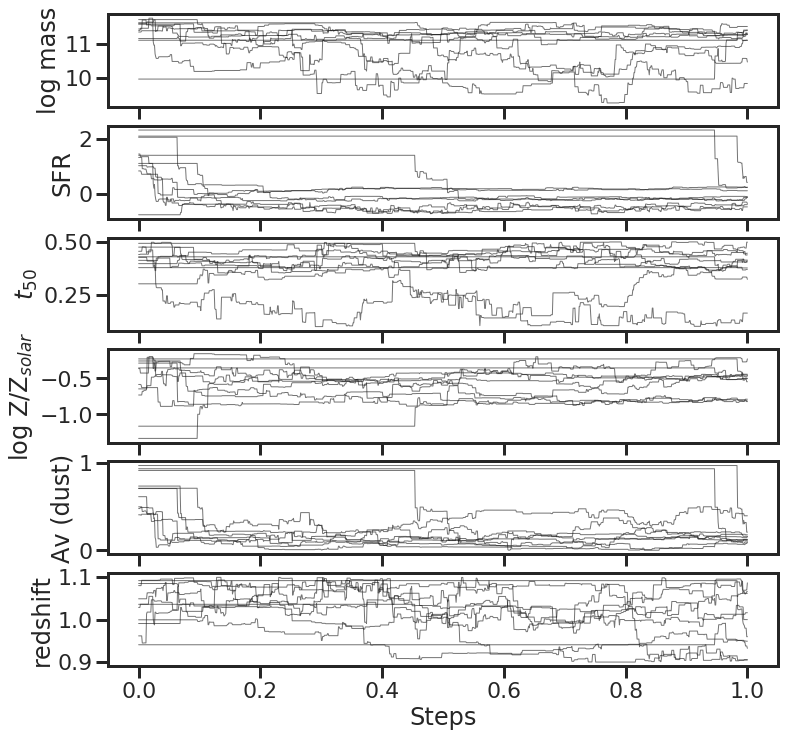

In [69]:
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(12, 12))
for i, [ax, param] in enumerate(zip(axes, ['log mass', r'SFR', r'$t_{50}$', r'log Z/Z$_{solar}$', 'Av (dust)','redshift'])):
    walkers = sampler.chain[:, :, i]
    for walker in walkers[::5]:
        ax.plot(np.linspace(0,1,nsteps), walker, lw=1.0, color='k', alpha=0.6)
    ax.set_ylabel(param)

#axes[ndim-1].set_yscale('log')
axes[ndim-1].set_xlabel('Steps');
plt.show()